In [14]:
import numpy as np 
import pickle
import gzip
import sys
sys.path.append('/burg/palab/users/wm2377/snakemake_versions/scripts/')
sys.path.append('/burg-archive/home/wm2377/cdwm/final_code_version/')
from common_functions import *
import simulations_10042023_classes
from scipy import stats
from scipy.optimize import root
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from copy import deepcopy as dc
from matplotlib import patches
from matplotlib import text as mtext
import math
from common_functions import *
import matplotlib.colors as colors



In [ ]:
# set the population size
N = 5000

# simple simulation
def update_allele_frequency(a,x,D):
    dx = a/(2*N)*(D-a*(1/2-x))*x*(1-x)
    x_deterministic = min(1,max(0,x + dx))
    x_random = np.random.binomial(2*N, x_deterministic)/(2*N)
    realized_dx = x_random - x
    return x_random, realized_dx

def next_gen(mutations,D,sigma2,N2U):
    new_mutations = []
    realized_change = 0
    for a,x in mutations:
        x_new, realized_dx = update_allele_frequency(a,x,D)
        if x_new > 0 and x_new < 1:
            new_mutations.append((a,x_new))
        realized_change += realized_dx*2*a
    
    for _ in range(np.random.poisson(N2U)):
        S = stats.expon(scale=400,loc=100).rvs()
        a = np.sqrt(S)
        sign = np.random.choice([-1,1])
        a = a*sign
        new_mutations.append((a,1/(2*N)))
        realized_change += 2*a*1/(2*N)
    
    D = D - realized_change - D*sigma2/(2*N)
    return new_mutations, D

# generate a random mutation effect and allele frequency from the steady state distribution for the exponential DFE
def get_seg_mutation_effect_and_freq():
    S = stats.expon(scale=400,loc=100).rvs()
    
    denominator = quad(lambda x: folded_sojourn_time(a=np.sqrt(S),x=x,N=N),0,1/2,points=[1/(2*N)])[0]
    p = np.random.random()
    try:
        x = root(lambda q: quad(lambda y: folded_sojourn_time(a=np.sqrt(S),x=y,N=N),0,q,points=[1/(2*N)])[0]/denominator-p,1/(2*N)).x[0]
    except:
        try:
            x = root(lambda q: quad(lambda y: folded_sojourn_time(a=np.sqrt(S),x=y,N=N),0,q,points=[1/(2*N)])[0]/denominator-p,1/(2*N)+1e-10).x[0]
        except:
            x = root(lambda q: quad(lambda y: folded_sojourn_time(a=np.sqrt(S),x=y,N=N),0,q,points=[1/(2*N)])[0]/denominator-p,1/(2*N)-1e-10).x[0]
    a = np.sqrt(S)
    sign = np.random.choice([-1,1])
    return a*sign,x
    
# calculate Va from a given set of mutations and sigma2
def calculate_Va(mutations,sigma2):
    Va = 0
    for a,x in mutations:
        Va += a**2*x*(1-x)
    Va += sigma2
    return Va

# calculate u3 from a given set of mutations. Assumes no contribution from small effect mutations 
def calculate_u3(mutations):
    u3 = 0
    for a,x in mutations:
        u3 += 2*a**3*x*(1-x)*(1-2*x)
    return u3

# approximate the steady state allele frequency distribution by bilinear interpolation
def find_nearest_S_and_p(S,p,steady_state_allele_frequency_distribution):
    # find closest two S_values from steady_state_allele_frequency_distribution keys
    S_values = list(steady_state_allele_frequency_distribution.keys())
    S_values.sort()
    S_values = np.array(S_values)
    S_max = 2863.1021115928543
    idx = (np.abs(S_values - S)).argmin()
    S_closest = S_values[idx]
    if idx == len(S_values)-1:
        S_closest2 = S_closest
    else:
        if S_closest < S:
            idx2 = idx+1
        else:
            idx2 = idx-1
        S_closest2 = S_values[idx2]
    
    # find closest two p_values from steady_state_allele_frequency_distribution[S_closest] keys
    p_values = list(steady_state_allele_frequency_distribution[S_closest].keys())
    p_values.sort()
    p_values = np.array(p_values)
    idx = (np.abs(p_values - p)).argmin()
    p_closest = p_values[idx]
    
    if p_closest < p:
        idx2 = idx+1
    else:
        idx2 = idx-1
    try:
        p_closest2 = p_values[idx2]
    except:
        print(p,p_values)
        raise ValueError
    
    # for each S interpolate between p_closest and p_closest2 for p
    x_stars = []
    for Si in [S_closest,S_closest2]:
        x1 = steady_state_allele_frequency_distribution[Si][p_closest]
        x2 = steady_state_allele_frequency_distribution[Si][p_closest2]
        x_star = x1 + (x2-x1)/(p_closest2-p_closest)*(p-p_closest)
        x_stars.append(x_star)
    
    # interpolate between S_closest and S_closest2 for S
    x1 = x_stars[0]
    x2 = x_stars[1]
    if S_closest == S_closest2:
        x_star = x1
    else:
        x_star = x1 + (x2-x1)/(S_closest2-S_closest)*(S-S_closest)
    
    return x_star
    
    
# run a simple simulation to capture how the phenotypic moments and distribution change over time
def recursion(shift,sigma2,N2U,n_seg,steady_state_allele_frequency_distribution,storage_times = [20,'dsq',300]):
    D = shift
    S_values = stats.expon(scale=400,loc=100).rvs(np.random.poisson(N2U*n_seg))
    sign_values = np.random.choice([-1,1],len(S_values))
    p_values = np.random.random(len(S_values))
    mutations = [(np.sqrt(S)*sign,find_nearest_S_and_p(S=S,p=p,steady_state_allele_frequency_distribution=steady_state_allele_frequency_distribution)) for S,sign,p in zip(S_values,sign_values,p_values)]
    VaD_moment_store = []
    mu3_moment_store = []
    DSQ = False
    
    results_store = {}
    t_values = [i for i in storage_times if type(i) == int]
    if len(t_values) == 0:
        t_values = [20000]
        break_on_dsq = True
    else:
        break_on_dsq = False
    t = 0
    while t < max(t_values)+1 or not DSQ:
  
        mutations, D = next_gen(mutations,D,sigma2,N2U)
        Va = calculate_Va(mutations,sigma2)
        u3 = calculate_u3(mutations)
        VaD_moment = Va*D/(2*N)
        mu3_moment = u3/(2*2*N)
        VaD_moment_store.append(VaD_moment)
        mu3_moment_store.append(mu3_moment)
        window_size = 10
        
        if t in storage_times:
            results_store[t] = dc((mutations,D,VaD_moment,mu3_moment,t))
            # print("t_current",t)
        
        try:
            if t > 20 and not DSQ:
                VaD_moment_average = np.mean(VaD_moment_store[-window_size:])
                mu3_moment_average = np.mean(mu3_moment_store[-window_size:])
                if np.isclose(VaD_moment_average,mu3_moment_average,rtol=5e-2) or t > 1e4:
                    results_store["dsq"] = dc((mutations,D,VaD_moment,mu3_moment,t))
                    DSQ = True
                    # print("t_SQ",t)
                    if break_on_dsq:
                        break
        except:
            pass
        
        t+=1
    return results_store 

# From a set of simulation results, generate the phenotype distribution at each time point
def generate_phenotype_distribution(results_all,sigma2=80):
    
    # Store the results here
    phenotype_distributions_all = {}
    
    
    # Do this for each of three time points. Beginning and end time points use the expected distributions
    for key in [20,'dsq',300]:
        
        # Find the mean D across all simulations at this time point
        D_mean = []
        for results in results_all:
            D_mean.append(results[key][1])
        D_mean = np.mean(D_mean)
        
        # Generate the phenotype distribution across all simulations at this time point
        phenotype_distribution = []
        
        i = 0
        # For each simulation, generate 5000 individuals and add to the overall phenotype distribution
        for results in results_all:
            
            # Keep track of which simulation we're on and reset temporary storage
            i += 1
            phenotype_distribution_temp = []

            # Unpack the results, we only really need the mutations
            mutations,D,VaD_moment,mu3_moment,t = results[key]
            # Generate genotype distributions for each mutation
            genotype_distributions = []
            # For each mutation, calculate the genotype distribution based on the allele frequency. If fixed or lost, ignore
            for a,x in mutations:
                if x > 0 or x < 1:
                    genotype_distributions.append((a,x,((1-x)**2,2*(1-x)*x,x**2)))
            
            # For 5000 individuals, generate a phenotype based on the genotype distributions and add to temporary storage
            for _ in range(5000):
                # start with normal deviate for background contribution
                b = np.random.normal(0,sigma2**(0.5))
                # add contribution from each segregating site
                for a,x,genotype_distribution in genotype_distributions:
                    m = np.random.choice([0,1,2],p=genotype_distribution)
                    b += a*m
                phenotype_distribution_temp.append(b)
            # recentre the temporary distribution and shift based on D_mean
            data_temp = np.array(phenotype_distribution_temp)
            data_temp_mean = np.mean(data_temp)
            data_temp = data_temp - data_temp_mean
            data_temp = data_temp + (80 - D_mean)
            phenotype_distribution.extend(data_temp)
        phenotype_distributions_all[key] = phenotype_distribution
        
    return phenotype_distributions_all


def get_results(snakemake,steady_state_allele_frequency_distribution,n=2,storage_times = [20,'dsq',300]):
    
    global N
    N = snakemake.params.N
    sigma2 = snakemake.params.sigma2
    N2U = snakemake.params.N2U
    shift = snakemake.params.shift
    
    results = []
    # calculate n_seg, the number of expected segregating alleles at steady state
    n_seg = quad(lambda S: stats.expon(scale=400,loc=100).pdf(S)*quad(lambda x: folded_sojourn_time(a=np.sqrt(S),x=x,N=N),0,1/2,points=[1/(2*N)])[0],0,np.inf)[0]
    for i in range(n):
        # Run the simulation and return the results at the given time points
        results_store = recursion(shift=shift,sigma2=sigma2,N2U=N2U,steady_state_allele_frequency_distribution=steady_state_allele_frequency_distribution,n_seg=n_seg,storage_times=storage_times)
        results.append(results_store)

    return results

class Snakemake:
    
    def __init__(self,params):
        self.params = params
        
class params:
    def __init__(self,N,sigma2,N2U,shift):
        self.N = N
        self.sigma2 = sigma2
        self.N2U = N2U
        self.shift = shift
        


In [3]:
# Calculate the approximate starting distribution for a given steady state distribution
def approx_starting_distribution(sdist):
    
    S_values = sdist.ppf(np.linspace(0,1,100)[:-1])
    p_values = np.linspace(0,1,102)
    # add 0.999 and 0.9999 to p_values
    p_values = np.concatenate([p_values,[0.999,0.9999]])
    
    
    starting_dist_dict = {}
    for S in S_values:
        denominator = quad(lambda x: folded_sojourn_time(a=np.sqrt(S),x=x,N=N),0,1/2,points=[1/(2*N)])[0]
        starting_dist_dict[S] = {}
        for p_raw in p_values:
            if p_raw == 0:
                x = 0
            else:
                if p_raw == 1:
                    p = 0.99999
                else:
                    p = p_raw
                
                try:
                    x = root(lambda q: quad(lambda y: folded_sojourn_time(a=np.sqrt(S),x=y,N=N),0,q,points=[1/(2*N)])[0]/denominator-p,1/(2*N)).x[0]
                except:
                    try:
                        x = root(lambda q: quad(lambda y: folded_sojourn_time(a=np.sqrt(S),x=y,N=N),0,q,points=[1/(2*N)])[0]/denominator-p,1/(2*N)+1e-10).x[0]
                    except:
                        x = root(lambda q: quad(lambda y: folded_sojourn_time(a=np.sqrt(S),x=y,N=N),0,q,points=[1/(2*N)])[0]/denominator-p,1/(2*N)-1e-10).x[0]
            starting_dist_dict[S][p_raw] = x
    return starting_dist_dict


In [ ]:

def plot_phenotype_distributions(ax,results_pheno_dists,phenotype_data_all,params):

    plt.sca(ax)
    # function for colors
    color_i = lambda i: [0.2+0.6*i,0.8-0.3*i,0.2]
    for t in phenotype_data_all.keys():
        
        # choose color
        if t == 'dsq':
            color = 'k'
        else:
            if t < 50:
                color = color_i(0)
                color = [i/2 for i in color]
            elif t == 999:
                continue
            else:
                color = color_i(1)
                color = [i/2 for i in color]
                   
        # get the right data 
        data = phenotype_data_all[t]
        
        # plot data
        g = sns.histplot(data, kde=True, stat='density',color=color)
        # remove histogram bars
        g.containers[0].remove()
        
    # plot steady state distributions
    sigma2 = params.sigma2
    data = np.random.normal(0,sigma2**(0.5),100000)
    old_steady_state_color = color_i(0)
    g = sns.histplot(data, kde=True, stat='density',color=color_i(0))
    g.containers[0].remove()

    data = np.random.normal(80,sigma2**(0.5),100000)
    new_steady_state_color = color_i(1)
    g = sns.histplot(data, kde=True, stat='density',color=color_i(1))
    g.containers[0].remove()

    # assign color names
    rapid_phase_color = [i/2 for i in color_i(0)]
    quasi_static_phase_color = [i/2 for i in color_i(1)]
    end_of_rapid_phase_color = 'k'
    
    # set the x ticks to just be 0 and the shift size and label them as new optimum and old optimum
    shift = params.shift
    plt.xticks([0,shift],[r'$0$',r'$\Lambda$'])

    # remove y ticks and label x axis
    plt.yticks([])
    plt.xlabel('Mean phenotype')
    plt.title('Evolution of phenotype distribution')

    # add legend
    x_legend_text = 165
    plt.text(x_legend_text,0.035,'Old steady state',color=old_steady_state_color,ha='center',va='center')
    plt.text(x_legend_text,0.025,'End of rapid phase',color=end_of_rapid_phase_color,ha='center',va='center')
    plt.text(x_legend_text,0.015,'New steady state',color=new_steady_state_color,ha='center',va='center')

    x_arrow = 140
    x_arrow_text = 165
    plt.gca().annotate('', xytext=(x_arrow, 0.033), xy=(x_arrow, 0.027), arrowprops=dict(arrowstyle='->',color=rapid_phase_color))
    plt.text(x_arrow_text,0.03,'Rapid\nphase',color=rapid_phase_color,ha='center',va='center')
    plt.gca().annotate('', xytext=(x_arrow, 0.023), xy=(x_arrow, 0.017), arrowprops=dict(arrowstyle='->',color=quasi_static_phase_color))
    plt.text(x_arrow_text,0.02,'Quasi-\nstatic\nphase',color=quasi_static_phase_color,ha='center',va='center')

    # add dashed lines to show where the mean phenotype is at each phase
    ## get lines    
    f=plt.gca().lines
    for i_index,i in enumerate(f):
        
        # get x and y data from lines
        x = i.get_xdata()
        y = i.get_ydata()
        
        # get color of line
        color = list(i.get_color()[:3])
        
        # determine which phase the line is in
        if color == rapid_phase_color:
            key = 20
            D_mean = []
            for results in results_pheno_dists:
                D_mean.append(results[key][1])
            D_mean = np.mean(D_mean)
            
        elif color == old_steady_state_color:
            D_mean = 80

        
        elif color == new_steady_state_color:
            D_mean = 0
        
        elif color == end_of_rapid_phase_color or color == [0,0,0]:
            key = 'dsq'
            D_mean = []
            for results in results_pheno_dists:
                D_mean.append(results[key][1])
            D_mean = np.mean(D_mean)
        
        elif color == quasi_static_phase_color:
            key = 300
            D_mean = []
            for results in results_pheno_dists:
                D_mean.append(results[key][1])
            D_mean = np.mean(D_mean)
        
        # plot dashed line at x value closest to D_mean and goes from 0 to the corresponding y value
        D_mean = 80 - D_mean
        x_closest = x[np.argmin(np.abs(x-D_mean))]
        y_closest = y[np.argmin(np.abs(x-D_mean))]
        plt.plot([x_closest,x_closest],[0,y_closest],color=color,linestyle='--',lw=1,alpha=0.5)

def make_phenotype_distributions_plot(sm,ax,steady_state_allele_frequency_distribution):
    # set seed so its reproducible
    np.random.seed(0)
    # get simulation results
    results_pheno_dists = get_results(snakemake=sm,n=100,storage_times = [20,'dsq',300],steady_state_allele_frequency_distribution=steady_state_allele_frequency_distribution)
    # turn that into phenotype data
    phenotype_data_all = generate_phenotype_distribution(results_pheno_dists,sigma2=sm.params.sigma2)
    plot_phenotype_distributions(ax=ax,results_pheno_dists=results_pheno_dists,phenotype_data_all=phenotype_data_all,params=sm.params)
    return results_pheno_dists, phenotype_data_all


In [ ]:
# this can take forever, so save the results to use later
sdist = stats.expon(scale=400,loc=100)
try:
    with open('./steady_state_allele_frequency_distribution.pickle','rb') as f:
        steady_state_allele_frequency_distribution = pickle.load(f)
except:
    steady_state_allele_frequency_distribution = approx_starting_distribution(sdist)
    with open('./steady_state_allele_frequency_distribution.pickle','wb') as f:
        pickle.dump(steady_state_allele_frequency_distribution,f)



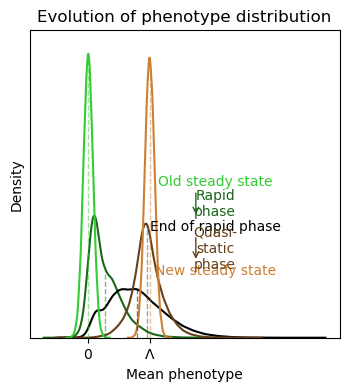

In [6]:
# This takes forever to run the first time, so we pickle the results
# then we can just load the pickled results later
# set what parameters we want
p = params(N=5000,sigma2=40,N2U=10,shift=80)
sm = Snakemake(p)
try:
    with open('./phenotype_distribution_data.pickle','rb') as f:
        results_pheno_dists, phenotype_data_all = pickle.load(f)
except:
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    results_pheno_dists, phenotype_data_all = make_phenotype_distributions_plot(sm=sm,ax=ax,steady_state_allele_frequency_distribution=steady_state_allele_frequency_distribution)
    with open('./phenotype_distribution_data.pickle','wb') as f:
        pickle.dump((results_pheno_dists,phenotype_data_all),f)


In [7]:
# # get a sample of length n via resampling
# def resample_to_n(results,n=1000):

#     if len(results) > n:
#         results_resampled = np.random.choice(results,n)
#     else:
#         results_resampled = results + [results[np.random.choice(range(len(results)))] for _ in range(n-len(results))]
#     return results_resampled
 
# # get the empirical cdf of allele frequencies   
# def get_empirical_cdf_of_allele_frequencies(ax,results,color,key='dsq'):
#     plt.sca(ax)
#     all_frequencies = []
#     bootstraps = {}
#     for i,sim in enumerate(results):
#         mutations,D,VaD_moment,mu3_moment,t = sim[key]
#         temp_frequencies = [x for a,x in mutations]
#         all_frequencies.extend(temp_frequencies)
#         bootstrap_index = int(i%20)
#         if bootstrap_index not in bootstraps:
#             bootstraps[bootstrap_index] = []
#         bootstraps[bootstrap_index].extend(temp_frequencies)
        

#     n = 200
#     cdf = np.linspace(0,1,n)
#     err = {c:[] for c in cdf}

#     # bootstrap
#     for bootstrap_index in bootstraps:
#         frequencies = bootstraps[bootstrap_index]
#         frequencies = resample_to_n(frequencies,n=n)
#         frequencies = np.array(frequencies)
#         frequencies = frequencies[frequencies > 0]
#         frequencies = frequencies[frequencies < 1]
#         frequencies = np.sort(frequencies)
        
#         for c,f in zip(cdf,frequencies):
#             err[c].append(f)
        
#     # get mean and std of bootstraps    
#     mean = {c:np.mean(err[c]) for c in err}
#     err = {c:np.std(err[c])/np.sqrt(len(err[c])) for c in err}
    
    
#     keys = list(mean.keys())
#     keys = np.array(keys)
#     values = np.array([mean[k] for k in keys])
#     ### sort values and keys by values
#     sorted_index = np.argsort(values)
#     keys = keys[sorted_index]
#     values = values[sorted_index]
#     err = [err[k] for k in keys]
#     p1, = plt.plot(values,keys,color=color)
#     p2 = plt.fill_betweenx(keys,values-err,values+err,alpha=0.2,color=color)
#     # plt.plot(list(mean.values()),list(mean.keys()),color=color)
    

#         # ax.plot(frequencies,cdf,label=r'$2NU=$'+f'{N2U}',color=color)
#     return p1,p2


# def plot_frequency_dist_at_DQS(ax,results_all,sdist,steady_state_allele_frequency_distribution):
#     plt.sca(ax)
#     legend_entries = {}
#     for N2U,color in zip([1,10,100],['green','teal','blue']):
#         p1,p2 = get_empirical_cdf_of_allele_frequencies(ax=ax,results=results_all[N2U],color=color)
#         legend_entries[r'$2NU=$'+f'{N2U}'] = (p1,p2)
#         # plt.plot(f_emp,c_emp,label=r'$2NU=$'+f'{N2U}',color=color)
        
#     S_values = sdist.rvs(10000)
#     p_values = np.random.random(10000)

#     no_shift = [(np.sqrt(S),find_nearest_S_and_p(S=S,p=p,steady_state_allele_frequency_distribution=steady_state_allele_frequency_distribution)) for S,p in zip(S_values,p_values)]
#     f = [x for a,x in no_shift]
#     f = np.array(f)
#     f = f[f > 0]
#     f = f[f < 1]
#     f = np.sort(f)
#     c = np.linspace(0,1,len(f))
#     # f,c = get_empirical_cdf_of_allele_frequencies(ax,[{'dsq':(no_shift,0,0,0,0)}],'k')
#     g1, = plt.plot(f,c,label='No shift',color='k')
#     legend_entries['No shift'] = g1
#     plt.xscale('log')
#     plt.xlim([1e-4,1])
#     plt.ylim([0,1])
#     # legend with 4 columns
#     plt.legend(legend_entries.values(),legend_entries.keys())
#     plt.xlabel('Frequency')
#     plt.ylabel('Cumulative density')
    
# def make_frequency_dist_plot(ax,steady_state_allele_frequency_distribution,sdist):
#     np.random.seed(0)
#     results_all = {}
#     for N2U in [1,10,100]:
#         p = params(5000,80,N2U,80)
#         sm = Snakemake(p)
#         results = get_results(snakemake=sm,steady_state_allele_frequency_distribution=steady_state_allele_frequency_distribution,n=100,storage_times = ['dsq'])
#         results_all[N2U] = results
#     plot_frequency_dist_at_DQS(ax=ax,results_all=results_all,sdist=sdist,steady_state_allele_frequency_distribution=steady_state_allele_frequency_distribution)
    


In [ ]:
# Another set of simulations to track allelic trajectories

def next_gen_to_get_allelic_trajectories(mutations,D,sigma2,N2U):
    new_mutations = []
    realized_change = 0
    for m in mutations:
        x_new, realized_dx = m.update(D)
        # only store allele trajectories that reach freq 0.01
        if x_new > 0.01:
            m.keep_forever = True
        # pass on all mutations that are still segregating or marked to be kept forever to the next generation
        if x_new > 0 and x_new < 1 or m.keep_forever:
            new_mutations.append(m)
        # update realized change
        realized_change += realized_dx*2*m.a
    
    # add new mutations
    for _ in range(np.random.poisson(N2U)):
        m = Mutationh(new=True)
        new_mutations.append(m)
        realized_change += 2*m.a*1/(2*N)
    
    # update distance
    D = D - realized_change - D*sigma2/(2*N)
    return new_mutations, D

# Short mutation class
class Mutationh:
    
    def __init__(self,new=False):
        if not new:
            a,x = get_seg_mutation_effect_and_freq()
        else:
            S = stats.expon(scale=400,loc=100).rvs()
            a = np.sqrt(S)
            sign = np.random.choice([-1,1])
            a = a*sign
            x = 1/(2*N)
        self.a = a
        self.x = x
        self.x_store = [x]
        self.keep_forever = False
        
    def update(self,D):
        x_new, realized_dx = update_allele_frequency(self.a,self.x,D)
        self.x = x_new
        self.x_store.append(x_new)
        return x_new, realized_dx
        
    def __repr__(self):
        return f'{self.a},{self.x}'
    
# Run a simulation to get allelic trajectories
def recursion_to_get_allelic_trajectories(shift,sigma2,N2U,n_seg):
    
    D = shift
    mutations = [Mutationh() for _ in range(np.random.poisson(N2U*n_seg))]
    D_store = []
    V_store = []
    for t in range(5000):
        if t % 100 == 0:
            print(t)
        mutations, D = next_gen_to_get_allelic_trajectories(mutations,D,sigma2,N2U)
        V_store.append(sum([2*m.a**2*m.x*(1-m.x) for m in mutations])+sigma2)
        D_store.append(D)
    return mutations, D_store, V_store


In [9]:
np.random.seed(0)

try:
    with open('allelic_trajectories.pkl','rb') as f:
        results_trajectories_small = pickle.load(f)
        results_trajectories_large = pickle.load(f)
except:
    print('h')
    print(sdist.mean())
    n_seg = quad(lambda S: quad(lambda x: folded_sojourn_time(a=np.sqrt(S),x=x,N=N),0,1/2,points=[1/(2*N)])[0]*(sdist.pdf(S)),100,10000)[0]
    print(n_seg)
    # results_trajectories = recursion_to_get_allelic_trajectories(80,80,10,n_seg*10)
    results_trajectories_small = recursion_to_get_allelic_trajectories(shift=80,sigma2=40,N2U=10,n_seg=n_seg)
    results_trajectories_large = recursion_to_get_allelic_trajectories(shift=80,sigma2=40,N2U=100,n_seg=n_seg)
    with open('allelic_trajectories.pkl','wb') as f:
        pickle.dump(results_trajectories_small,f)
        pickle.dump(results_trajectories_large,f)
    # trajectories_lost = [m.a**2 for m in results_trajectories if m.keep_forever and m.x_store[-1] < 0.5]
    # trajectories_fixed = [m.a**2 for m in results_trajectories if m.x_store[-1] > 0.5]
    # assert len(trajectories_fixed)>0


h
500.0
7.436985558781047
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [12]:



def plot_trajectory_figure(axes,lost,fixed,plot_fixed,dsq_time):
    large_count = 0
    small_count = 0
    cmap = plt.get_cmap('winter_r')
    cmap_small = cmap
    cmap_large = cmap
    ## log norm between 100 and 1200
    norm = mpl.colors.Normalize(vmin=100,vmax=2000)
    norm_small = norm
    norm_large = norm

    for m in lost:
        t_arise = 5000-len(m.x_store)
        if t_arise > 1:
            continue
        time_values = np.linspace(t_arise,5000,len(m.x_store))
        
        # color = cmap_small(norm_small(sdist.cdf(m.a**2)))
        color = cmap_small(norm_small(m.a**2))
        color = np.array(color)
        if small_count < 10 and m.a > 0:

            axes[0].plot(time_values,m.x_store,color=color)
            small_count += 1
        # elif m.a**2 > 500 and large_count < 5 and m.a > 0:
        #     large_count += 1
        #     axes[0].plot(time_values,m.x_store,color=color)

    if plot_fixed:
        for m in fixed:
            t_arise = 5000-len(m.x_store)
            time_values = np.linspace(t_arise,5000,len(m.x_store))
            axes[0].plot(time_values,m.x_store,color=cmap_small(norm_small(sdist.cdf(m.a**2))))
            # break

    for ax in axes:
        ax.set_xscale('log')
        ax.set_xlim([1,2000])
        ax.set_ylim([1e-4,1])
        ax.set_yscale('log')
        
        ax.set_xlabel('Time since shift (generations)')
        ax.set_ylabel('Frequency')

    axes[0].fill_between([0,dsq_time],[1e-4,1e-4],[1,1],color='k',alpha=0.2,edgecolor=None)
    
def categorize_trajectories(trajectories):
    fixed = [m for m in trajectories if m.x_store[-1] > 0.5 and m.keep_forever]
    lost = [m for m in trajectories if m.x_store[-1] < 0.5 and m.keep_forever]
    ### Shuffle lost
    np.random.seed(1)
    np.random.shuffle(lost)
    return lost,fixed

def get_trajectories(sm,n_seg):
    
    np.random.seed(1)
    trajectories = recursion_to_get_allelic_trajectories(shift=sm.params.shift,sigma2=sm.params.sigma2,N2U=sm.params.N2U,n_seg=n_seg)
    return trajectories

def make_trajectory_figure(axes,sm,sdist):

    
    n_seg = quad(lambda S: sdist.pdf(S)*quad(lambda x: folded_sojourn_time(a=np.sqrt(S),x=x,N=N),0,1/2,points=[1/(2*N)])[0],0,np.inf)[0]
    trajectories = get_trajectories(sm,n_seg)
    lost,fixed = categorize_trajectories(trajectories[0])
    plot_trajectory_figure(axes,lost,fixed)
    
    
# fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(8,8),dpi=400)
# # make_trajectory_figure(axes,sm,sdist)
# lost,fixed = categorize_trajectories(results_trajectories_small[0])
# plot_trajectory_figure([axes[0][1],axes[1][1]],lost,fixed,plot_fixed=True,dsq_time = 82)


# lost,fixed = categorize_trajectories(results_trajectories_large[0])
# plot_trajectory_figure([axes[1][1],axes[0][1]],lost,fixed,plot_fixed=False,dsq_time=21)

# ### add colorbar to axes[0]
# cmap = plt.get_cmap('winter_r')
# norm = mpl.colors.Normalize(vmin=100,vmax=2000)
# sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm,ax=axes[1][1],extend='max')
# cbar.set_label('Effect size')
# cbar.set_ticks([100,500,1000,1500,2000])
# cbar = plt.colorbar(sm,ax=axes[0][1],extend='max')
# cbar.set_label('Effect size')
# cbar.set_ticks([100,500,1000,1500,2000])
# axes[0][0].set_title(r'$\bf{A.}$ Phenotypic mean trajectory')
# axes[0][1].set_title(r'$\bf{B.}$ Allele trajectories given $2NU=10$')
# axes[1][1].set_title(r'$\bf{D.}$ Allele trajectories given $2NU=100$')
# axes[1][0].set_title(r'$\bf{C.}$ Evolution of phenotypic distribution given $2NU=10$')
# plt.subplots_adjust(hspace=0.3,wspace=0.3)
# p = params(N=5000,sigma2=80,N2U=10,shift=80)
# sm = Snakemake(p)
# # plot_phenotype_distributions(ax=axes[1][0],results_pheno_dists=results_pheno_dists,phenotype_data_all=phenotype_data_all,params=sm.params)

# lande_time = np.logspace(0,4,1000)
# lande_distance = 80*np.exp(-(lande_time-1)/(1e4)*(80+4*10))
# axes[0][0].plot(lande_time,lande_distance,color='k',linestyle='-')
# axes[0][0].set_xscale('log')

# for S in [100,500,1000]:
#     dist = np.sqrt(S)/2
#     axes[0][0].plot([0,2e4],[dist]*2,color=cmap(norm(S)))
# axes[0][0].set_xlim([1,1e4])
# axes[0][0].set_ylim([0,80])
# # cbar.set_ticklabels([round(sdist.ppf(0)),round(sdist.ppf(0.5)),round(sdist.ppf(0.99))])

# for N2U,color in zip([100,10],[[1,0.4,0.4],[0.5,0.2,0.2]]):
#     with open(f'/burg/palab/users/wm2377/snakemake_versions/figures/sdist_expon/phenotypic_trajectories_N2U_{N2U}.0_shift_80_sigma2_80.png.dtraj.pickle','rb') as f:
#         results_trajectories = pickle.load(f)
#     axes[0][0].plot(results_trajectories[0],results_trajectories[1],label=f'$2NU={N2U}$',color=color)


In [15]:


external_fontsize = 11
internal_fontsize = 11
inset_fontsize = 11

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap_old = plt.get_cmap('gist_earth_r')
cmap_old_new = truncate_colormap(cmap_old, 0.3, 0.9)

def mute_color(color,mute=0.85):
    temp = [(i*mute+1*(1-mute)) for i in color]
    temp[-1] = 1
    return temp

# extract all colors from the .jet map
cmaplist = [mute_color(mpl.colors.to_rgba('goldenrod')),mute_color(mpl.colors.to_rgba('teal')),mute_color(cmap_old_new(0.9))]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, len(cmaplist))
cmap.set_over(mute_color(cmap_old_new(0.9)))
# define the bins and normalize
bounds = [100,200,500,1500]
norm = mpl.colors.BoundaryNorm(bounds, len(cmaplist))

def plot_trajectory_figure(axes,lost,fixed,plot_fixed,dsq_time,lw=1,lw_fixed=3):
    
    large_count = 0
    small_count = 0
    extra_large_count = 0
    extra_extra_large_count = 0
    # cmap = plt.get_cmap('winter_r')
    cmap_small = cmap
    cmap_large = cmap
    ## log norm between 100 and 1200
    # norm = mpl.colors.Normalize(vmin=0,vmax=sdist.cdf(2000))
    # norm = mpl.colors.Normalize(vmin=100,vmax=2000)
    norm_small = norm
    norm_large = norm

    for m in lost:
        t_arise = 5000-len(m.x_store)
        if t_arise > 1:
            continue
        time_values = np.linspace(t_arise,5000,len(m.x_store))
        
        # color = cmap_small(norm_small(sdist.cdf(m.a**2)))
        normed_value = norm_small(m.a**2)#*0.6+0.3
        color = cmap_small(normed_value)
        color = np.array(color)
        if small_count < 2 and m.a > 0 and m.a**2 < 200:
            axes[0].plot(time_values,m.x_store,color=color,lw=lw)
            small_count += 1
            
        elif m.a**2 > 200 and large_count < 2 and m.a > 0 and m.a**2 < 500:
            large_count += 1
            axes[0].plot(time_values,m.x_store,color=color,lw=lw)

        elif m.a**2 > 500 and m.a**2 < 15000 and extra_large_count < 2 and m.a > 0:
            extra_large_count += 1
            axes[0].plot(time_values,m.x_store,color=color,lw=lw)
        
        elif m.a**2 > 1500 and extra_extra_large_count < 2 and m.a > 0:
            extra_extra_large_count += 1
            axes[0].plot(time_values,m.x_store,color=color,lw=lw)
            
    if plot_fixed:
        for m in fixed:
            print(m.a**2)
            normed_value = norm_small(m.a**2)
            color = cmap_small(normed_value)
            color = np.array(color)
            t_arise = 5000-len(m.x_store)
            time_values = np.linspace(t_arise,5000,len(m.x_store))
            axes[0].plot(time_values,m.x_store,color=color,lw=lw_fixed)
            fixed_a2 = m.a**2
            break
            # break

    for ax in axes:
        ax.set_xscale('log')
        ax.set_xlim([1,2000])
        ax.set_ylim([1e-4,1])
        ax.set_yscale('log')
        
        ax.set_xlabel('Time since shift (generations)',fontsize=external_fontsize)
        ax.set_ylabel('Frequency',fontsize=external_fontsize)

    axes[0].fill_between([0,dsq_time],[1e-4,1e-4],[1,1],color='k',alpha=0.1,edgecolor=None)
    return fixed_a2

def categorize_trajectories(trajectories):
    fixed = [m for m in trajectories if m.x_store[-1] > 0.5 and m.keep_forever]
    lost = [m for m in trajectories if m.x_store[-1] < 0.5 and m.keep_forever]
    ### Shuffle lost
    np.random.seed(1)
    np.random.shuffle(lost)
    return lost,fixed

def get_trajectories(sm,n_seg):
    
    np.random.seed(1)
    trajectories = recursion_to_get_allelic_trajectories(shift=sm.params.shift,sigma2=sm.params.sigma2,N2U=sm.params.N2U,n_seg=n_seg)
    return trajectories

def make_trajectory_figure(axes,sm,sdist):

    
    n_seg = quad(lambda S: sdist.pdf(S)*quad(lambda x: folded_sojourn_time(a=np.sqrt(S),x=x,N=N),0,1/2,points=[1/(2*N)])[0],0,np.inf)[0]
    trajectories = get_trajectories(sm,n_seg)
    lost,fixed = categorize_trajectories(trajectories)
    plot_trajectory_figure(axes,lost,fixed)
    

def plot_phenotype_distributions(ax,results_pheno_dists,phenotype_data_all,params):

    plt.sca(ax)
    # function for colors
    cmap = mpl.cm.get_cmap('Greys')
    color_i = lambda i: cmap(i/4*0.8+0.2)
    for t in phenotype_data_all.keys():
        
        # choose color
        if t == 'dsq':
            color_index = 2
        else:
            if t < 50:
                color_index = 1
            elif t == 999:
                continue
            else:
                color_index = 3

        color = color_i(color_index)
        # get the right data 
        data = phenotype_data_all[t]
        
        # plot data
        g = sns.histplot(data, kde=True, stat='density',color=color)
        # remove histogram bars
        g.containers[0].remove()
        
    # plot steady state distributions
    sigma2 = params.sigma2
    data = np.random.normal(0,sigma2**(0.5),100000)
    old_steady_state_color = color_i(0)
    g = sns.histplot(data, kde=True, stat='density',color=old_steady_state_color)
    g.containers[0].remove()

    data = np.random.normal(80,sigma2**(0.5),100000)
    new_steady_state_color = color_i(4)
    g = sns.histplot(data, kde=True, stat='density',color=new_steady_state_color)
    g.containers[0].remove()

    # assign color names
    rapid_phase_color = color_i(1)
    quasi_static_phase_color = color_i(3)
    end_of_rapid_phase_color = color_i(2)
    
    # set the x ticks to just be 0 and 80 and label them as new optimum and old optimum
    shift = params.shift
    plt.xticks([0,shift],[r'$0$',r'$\Lambda$'])

    # remove y ticks and label x axis
    plt.yticks([])

    # # add legend
    # x_legend_text = 165
    # plt.text(x_legend_text,0.035,'Old steady state',color=old_steady_state_color,ha='center',va='center')
    # plt.text(x_legend_text,0.025,'End of rapid phase',color=end_of_rapid_phase_color,ha='center',va='center')
    # plt.text(x_legend_text,0.015,'New steady state',color=new_steady_state_color,ha='center',va='center')

    # x_arrow = 140
    # x_arrow_text = 165
    # plt.gca().annotate('', xytext=(x_arrow, 0.033), xy=(x_arrow, 0.027), arrowprops=dict(arrowstyle='->',color=rapid_phase_color))
    # plt.text(x_arrow_text,0.03,'Rapid\nphase',color=rapid_phase_color,ha='center',va='center')
    # plt.gca().annotate('', xytext=(x_arrow, 0.023), xy=(x_arrow, 0.017), arrowprops=dict(arrowstyle='->',color=quasi_static_phase_color))
    # plt.text(x_arrow_text,0.02,'Quasi-\nstatic\nphase',color=quasi_static_phase_color,ha='center',va='center')

    # add dashed lines to show where the mean phenotype is at each phase
    ## get lines    
    f=plt.gca().lines
    for i_index,i in enumerate(f):
        
        # get x and y data from lines
        x = i.get_xdata()
        y = i.get_ydata()
        
        # get color of line
        color = tuple(i.get_color())
        print('color',color,rapid_phase_color)
        
        # determine which phase the line is in
        if color == rapid_phase_color:
            key = 20
            D_mean = []
            for results in results_pheno_dists:
                D_mean.append(results[key][1])
            D_mean = np.mean(D_mean)
            
        elif color == old_steady_state_color:
            D_mean = 80

        
        elif color == new_steady_state_color:
            D_mean = 0
        
        elif color == end_of_rapid_phase_color or color == [0,0,0]:
            key = 'dsq'
            D_mean = []
            for results in results_pheno_dists:
                D_mean.append(results[key][1])
            D_mean = np.mean(D_mean)
        
        elif color == quasi_static_phase_color:
            key = 300
            D_mean = []
            for results in results_pheno_dists:
                D_mean.append(results[key][1])
            D_mean = np.mean(D_mean)
        
        print(color)
        sys.stdout.flush()
        # plot dashed line at x value closest to D_mean and goes from 0 to the corresponding y value
        D_mean = 80 - D_mean
        x_closest = x[np.argmin(np.abs(x-D_mean))]
        y_closest = y[np.argmin(np.abs(x-D_mean))]
        plt.plot([x_closest,x_closest],[0,y_closest],color=color,linestyle='--',lw=1,alpha=0.5)

    


112.71704410569639


/local/ipykernel_1249637/1537191075.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Greys')


color (0.7105882352941176, 0.7105882352941176, 0.7105882352941176, 1) (0.7105882352941176, 0.7105882352941176, 0.7105882352941176, 1.0)
(0.7105882352941176, 0.7105882352941176, 0.7105882352941176, 1)
color (0.47843137254901963, 0.47843137254901963, 0.47843137254901963, 1) (0.7105882352941176, 0.7105882352941176, 0.7105882352941176, 1.0)
(0.47843137254901963, 0.47843137254901963, 0.47843137254901963, 1)
color (0.25098039215686274, 0.25098039215686274, 0.25098039215686274, 1) (0.7105882352941176, 0.7105882352941176, 0.7105882352941176, 1.0)
(0.25098039215686274, 0.25098039215686274, 0.25098039215686274, 1)
color (0.8870588235294118, 0.8870588235294118, 0.8870588235294118, 1) (0.7105882352941176, 0.7105882352941176, 0.7105882352941176, 1.0)
(0.8870588235294118, 0.8870588235294118, 0.8870588235294118, 1)
color (0.0, 0.0, 0.0, 1) (0.7105882352941176, 0.7105882352941176, 0.7105882352941176, 1.0)
(0.0, 0.0, 0.0, 1)


/local/ipykernel_1249637/2900958355.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_time = mpl.cm.get_cmap('Greys')


[ 699.82171822 1781.82332968]
[ 699.82171822 1864.55277944]
[ 699.82171822 1974.48118589]


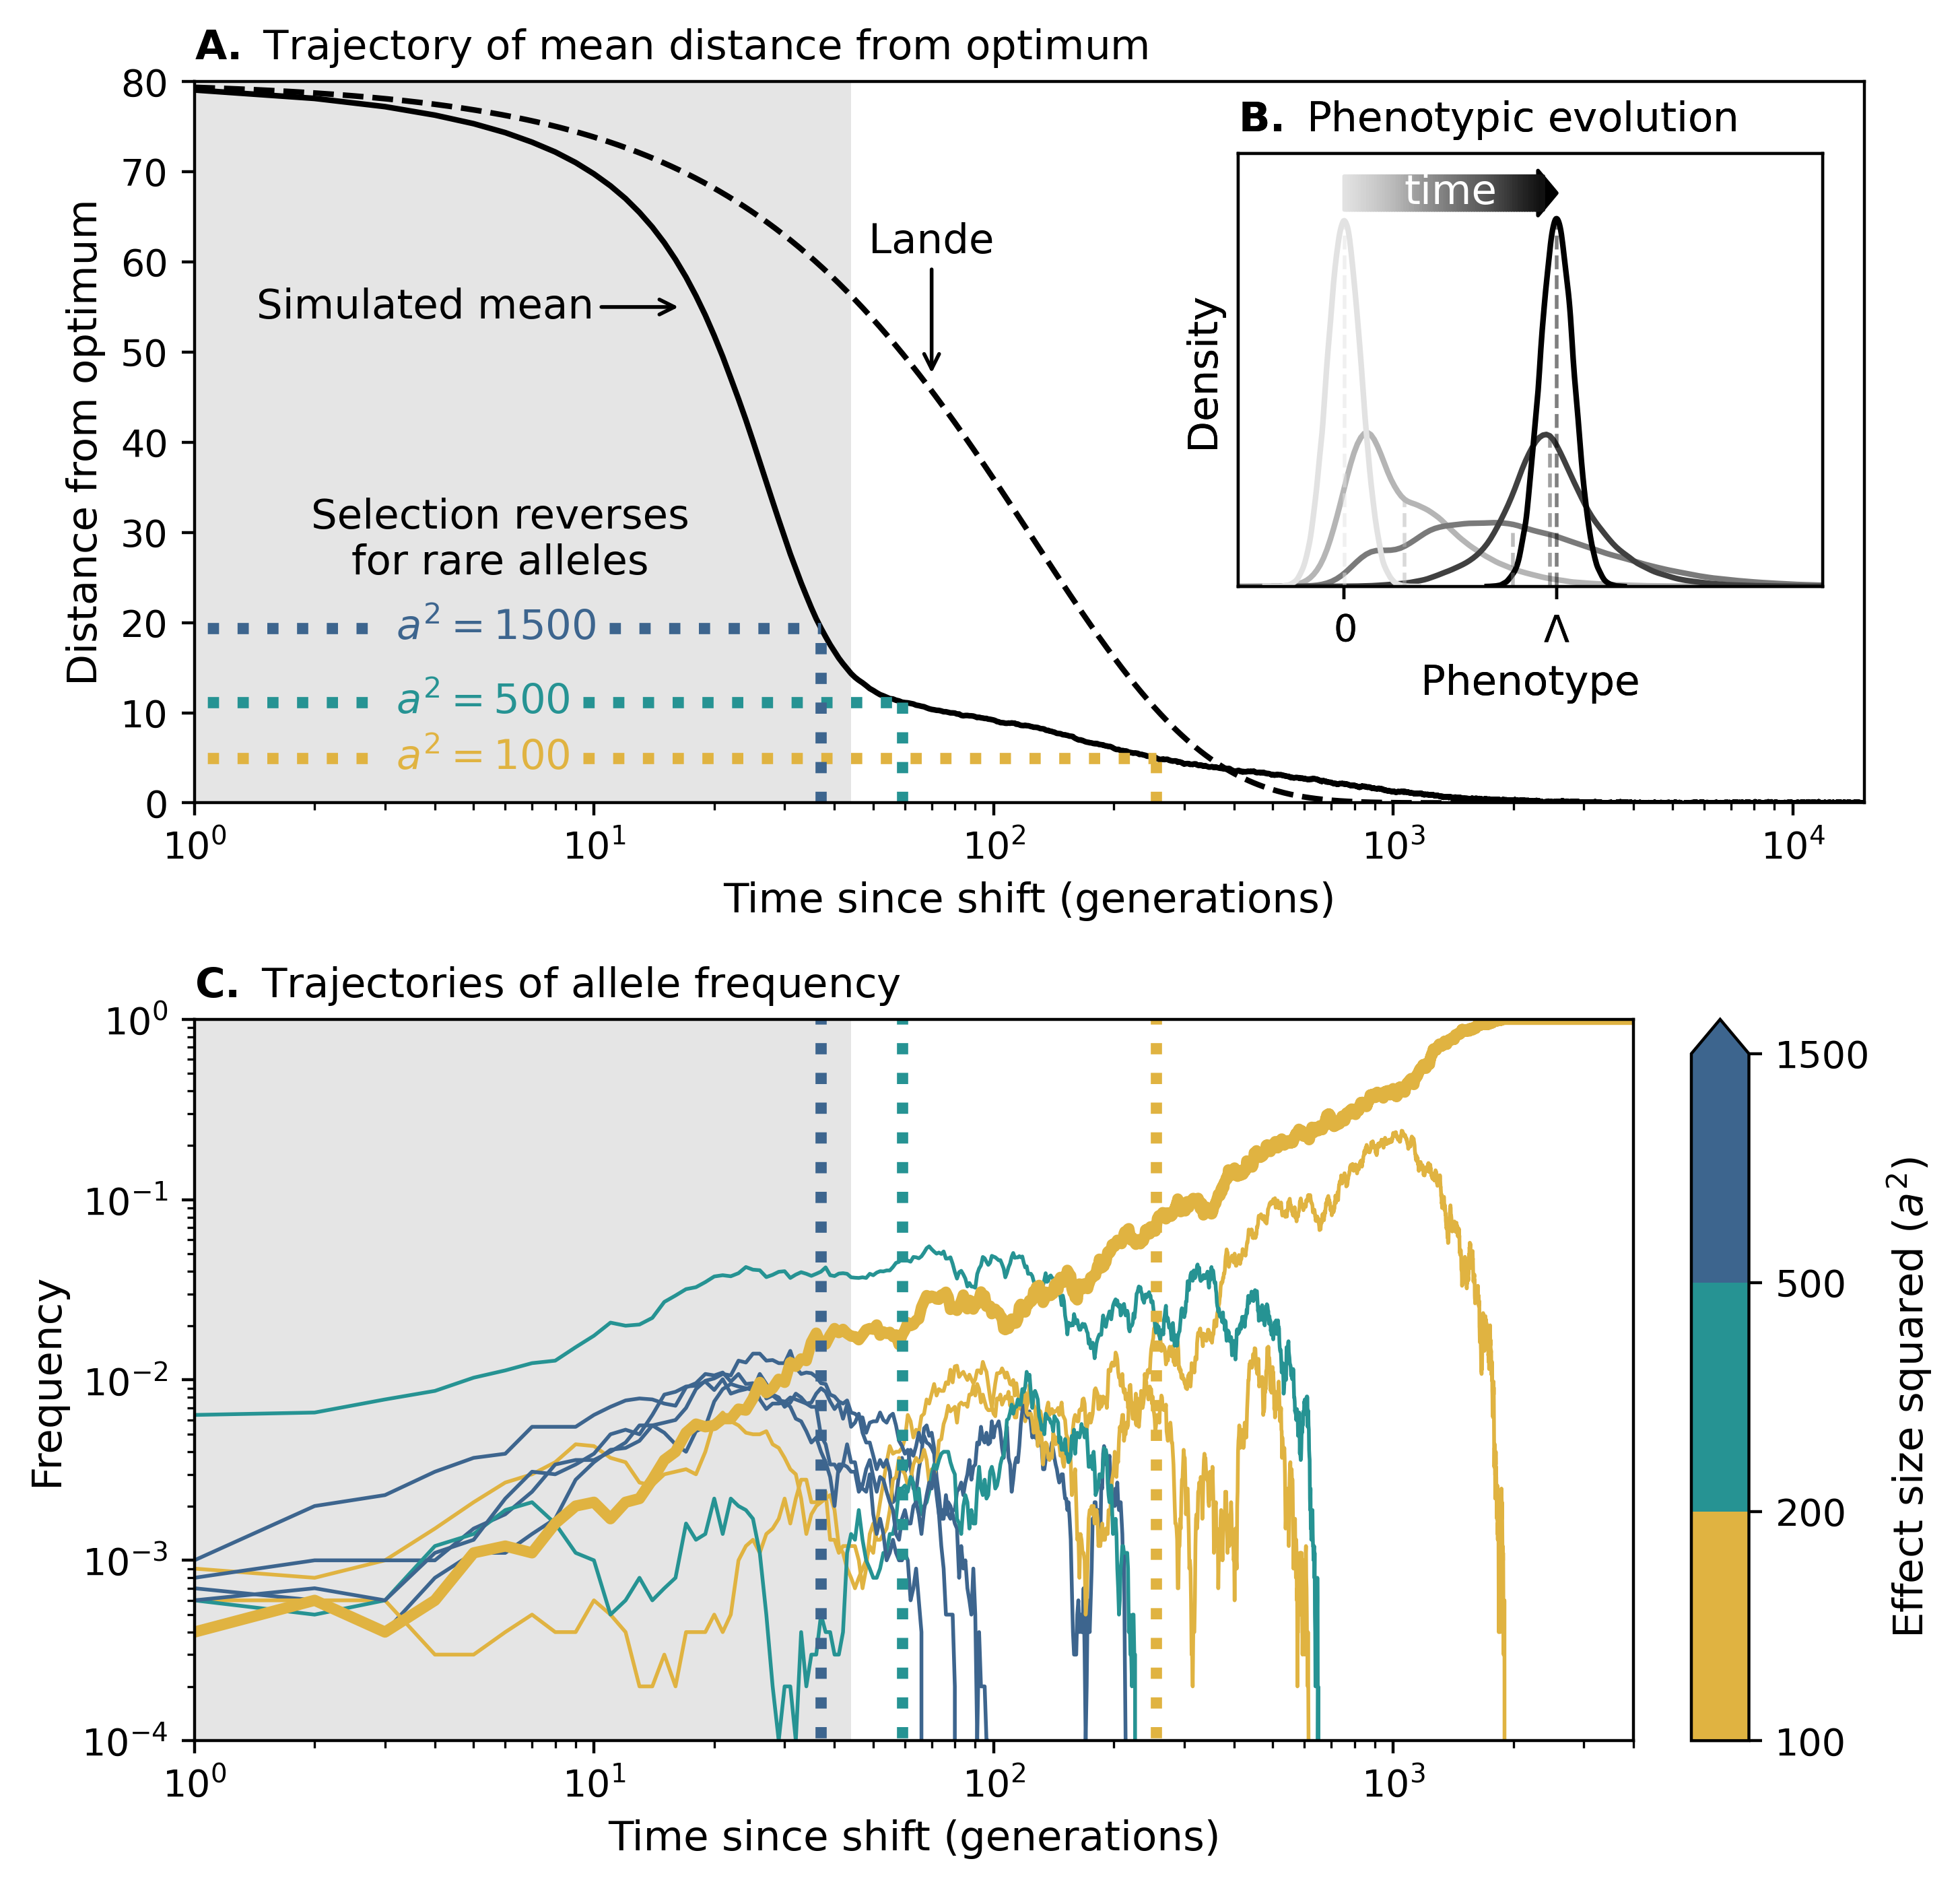

In [ ]:
# fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(8,8),dpi=400,gridspec_kw={'width_ratios': [25, 1, 1]})
fig,axes = plt.subplot_mosaic("AAAA;BCDE",figsize=(8,8),dpi=400,gridspec_kw={'width_ratios': [25, 1, 1,2]})
axes['C'].axis('off')
axes['E'].axis('off')

ax_trajectory = axes['B']
ax_colorbar = axes['D']
ax_distance = axes['A']

lost,fixed = categorize_trajectories(results_trajectories_large[0])
fixed_a2 = plot_trajectory_figure([ax_trajectory],lost,fixed,plot_fixed=True,dsq_time=44)

### add colorbar to axes[0]
vmin=100
# norm = mpl.colors.Normalize(vmin=vmin,vmax=2000)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
cbar = mpl.colorbar.ColorbarBase(ax_colorbar,cmap=cmap,norm=norm,orientation='vertical',extend='max',boundaries=bounds)
cbar.set_label(r'Effect size squared $(a^2)$',fontsize=external_fontsize)
cbar.set_ticks([100,200,500,1500])
cbar.set_ticklabels([100,200,500,1500])
# cbar.ax.plot([0,1],[fixed_a2,fixed_a2],color='k')
# ax_trajectory.text(x=400,y=0.4,s=r'Fixed $a^2 \approx 110$',color='k',ha='right',va='center',fontsize=internal_fontsize)
### add an annotation arrow
# ax_trajectory.annotate('', xy=(800, 0.4), xytext=(400, 0.4),arrowprops=dict(arrowstyle='->',color='k'))


ax_distance.set_title(r'$\bf{A.}$ Trajectory of mean distance from optimum',fontsize=external_fontsize,loc='left')
ax_trajectory.set_title(r'$\bf{C.}$ Trajectories of allele frequency',fontsize=external_fontsize,loc='left')

## make inset ax
axins = ax_distance.inset_axes(
        [0.625, 0.3, 0.35, 0.6], xticklabels=[], yticklabels=[],zorder=1)
fig.add_axes(axins)


p = params(N=5000,sigma2=40,N2U=10,shift=80)
sm = Snakemake(p)
plot_phenotype_distributions(ax=axins,results_pheno_dists=results_pheno_dists,phenotype_data_all=phenotype_data_all,params=sm.params)
axins.set_title(r'$\bf{B.}$ Phenotypic evolution',fontsize=inset_fontsize,loc='left')
axins.set_ylabel('Density',size=inset_fontsize)
axins.set_xlabel('Phenotype',size=inset_fontsize)
axins.set_xlim([-40,180])
ylim = axins.get_ylim()
axins.set_ylim([0,ylim[1]*1.1])
# axins.text(x=40,y=ylim[1],s='time',color='k',ha='center',va='center',fontsize=8)

shift = 80
arrow_height = ylim[1]
cmap_time = mpl.cm.get_cmap('Greys')
axins.annotate('',
            xy=(shift, arrow_height), xycoords='data',
            xytext=(10,arrow_height), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.0,headlength=5),
            horizontalalignment='center', verticalalignment='bottom')
for i in range(shift-5):
    axins.annotate('',
            xy=(i+1, arrow_height), xycoords='data',
            xytext=(i,arrow_height), textcoords='data',
            arrowprops=dict(facecolor=cmap_time(i/shift*0.8+0.2), width=9, shrink=0.02,headlength=0.01,headwidth=1,edgecolor=cmap_time(i/shift*0.8+0.2)),
            horizontalalignment='center', verticalalignment='bottom')

axins.text(x=shift/2,y=arrow_height,s=r'time',horizontalalignment='center',verticalalignment='center',size=inset_fontsize,color='white')


plt.subplots_adjust(hspace=0.3,wspace=0)
lande_time = np.logspace(0,4,1000)
# lande_time = np.append(np.linspace(0,1,100)[:-1],lande_time)
lande_distance = 80*np.exp(-(lande_time)/(1e4)*(40+4*10))
# lande_time_plottable = np.append(np.logspace(np.log10(0.5),0,100)[:-1],np.logspace(0,4,1000))
ax_distance.plot(lande_time,lande_distance,color='k',linestyle='--')
ax_distance.set_xscale('log')
ax_distance.text(x=70,y=60,s='Lande',va='bottom',ha='center',color='k',fontsize=internal_fontsize)
ax_distance.annotate('', xy=(70, 1.025*80*np.exp(-(70)/(1e4)*(40+4*10))), xytext=(70, 60),arrowprops=dict(arrowstyle='->',color='k'))

ax_distance.text(x=10,y=55,s='Simulated mean',va='center',ha='right',color='k',fontsize=internal_fontsize)
ax_distance.annotate('', xy=(17, 55), xytext=(10, 55),arrowprops=dict(arrowstyle='->',color='k'))

# for S in [100,500,1000]:
#     dist = np.sqrt(S)/2
#     axes[0][0].plot([0,2e4],[dist]*2,color=cmap(norm(S)))
ax_distance.set_xlim([1,1e4])
ax_distance.set_ylim([0,80])
ax_distance.set_xlabel('Time since shift (generations)',fontsize=external_fontsize)
ax_distance.set_ylabel('Distance from optimum',fontsize=external_fontsize)
# cbar.set_ticklabels([round(sdist.ppf(0)),round(sdist.ppf(0.5)),round(sdist.ppf(0.99))])
ax_trajectory.set_xlim([1,4000])
ax_distance.set_xlim([1,10**(np.log10(4000)*(29/25))])
for N2U,color in zip([10],['k']):
    with open(f'/burg/palab/users/wm2377/snakemake_versions/figures/sdist_expon/phenotypic_trajectories_N2U_{N2U}.0_shift_80_sigma2_40.png.dtraj.pickle','rb') as f:
        results_trajectories = pickle.load(f)
    times = np.array(results_trajectories[0],dtype=float)-1
    times[0]=0.5
    values = np.array(results_trajectories[1])
    values[0] = 80
    ax_distance.plot(times,values,color=color)
    ax_distance.fill_between([0,44],[0,0],[90,90],color='k',alpha=0.1,edgecolor=None)
    
    ## find time and value where value is closest to 10
    annotation_time = 0
    annotation_value = 0
    for index,S in enumerate([100,499,1500]):
        min_D = np.sqrt(S)/2
        time = times[np.argmin(np.abs(values-min_D))]
        value = values[np.argmin(np.abs(values-min_D))]
        if S == 1500:
            annotation_time = time
            annotation_value = value
        ax_distance.plot([time,time],[0,value],color=cmap(norm(S)),linestyle=':',lw=3)
        ax_trajectory.plot([time,time],[0,value],color=cmap(norm(S)),linestyle=':',lw=3)
        
        x_text = 3.2
        if S == 499:
            S_plot = 500
        else:
            S_plot = S
        t=ax_distance.text(x=x_text,y=value,s=r'$a^2=$'+str(S_plot),va='center',ha='left',color=cmap(norm(S)),fontsize=internal_fontsize)
        r = fig.canvas.get_renderer()
        bb = t.get_window_extent(renderer=r)
        # print(dir(bb))
        print(bb.corners()[0])
        width = bb.width
        height = bb.height
        inv = ax_distance.transData.inverted()
        ## get the x and y in data coordinates
        x_min,y = inv.transform(bb.corners()[0])
        x_max,y = inv.transform(bb.corners()[2])
        ax_distance.plot([0,x_min*0.925],[value,value],color=cmap(norm(S)),linestyle=':',lw=3)
        ax_distance.plot([x_max*1.075,time],[value,value],color=cmap(norm(S)),linestyle=':',lw=3)
        
        # ax_distance.scatter(time, value, marker='*', color=cmap(norm(S)), zorder=3, s= 72)
ax_distance.text(x=annotation_time*0.15*21/20,y=annotation_value+5,s='Selection reverses\nfor rare alleles',va='bottom',ha='center',color='k',fontsize=internal_fontsize)
# ax_distance.annotate('', xy=(annotation_time*0.95, annotation_value), xytext=(21, annotation_value),arrowprops=dict(arrowstyle='->',color=cmap(norm(2000))))
plt.savefig('ShortPaper_Figure5.png',bbox_inches='tight',dpi=400)
